<a href="https://colab.research.google.com/github/arqavan94/Persian_NLP_Task/blob/main/sequence_tagger_deepmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install hazm
!pip install fasttext

In [ ]:
# import fasttext.util
# fasttext.util.download_model('fa', if_exists='ignore')
# !gunzip /content/drive/MyDrive/cc.fa.300.vec.gz

'cc.fa.300.bin'

In [2]:
import numpy as np
import fasttext
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation, SimpleRNN,GRU
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import seaborn as sns
from hazm import PeykareReader
from sklearn.model_selection import train_test_split
from keras import backend as K
from hazm  import Normalizer
from hazm import WordTokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import pickle as pkl
from keras import metrics
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Data**

In [5]:
text_labels= np.load('/content/drive/MyDrive/text_labels.npz', allow_pickle=True)
text_labels.files
text_labels= text_labels['arr_0']

In [ ]:
print(len(text_labels))

344736


In [ ]:
point = int(.1 * len(text_labels))
main_data = text_labels[:point]
remain_data = text_labels[point:]

In [ ]:
sentences, sentence_tags =[], [] 
for tagged_sentence in text_labels:
    sentence, tags = zip(*tagged_sentence)
    sentences.append(list(sentence))
    sentence_tags.append(list(tags))

# **Convert text to number**

In [ ]:
# Tokenize the sentences
word_tokenizer= Tokenizer()
word_tokenizer.fit_on_texts(sentences)
X_encoded= word_tokenizer.texts_to_sequences(sentences)

In [ ]:
word_index = word_tokenizer.word_index
print('Word index:', word_index)

In [ ]:
tag_tokenizer= Tokenizer()
tag_tokenizer.fit_on_texts(sentence_tags)
Y_encoded= tag_tokenizer.texts_to_sequences(sentence_tags)

print('Y: ', Y_encoded[0],'\n')

Y:  [1, 4, 4, 2, 2, 7, 4, 1, 3, 2, 2, 1, 3, 1, 4, 8, 4] 



In [ ]:
lengths=[len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 1210


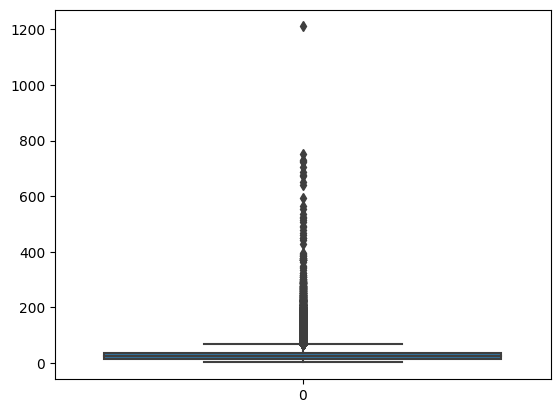

In [ ]:
sns.boxplot(lengths)
plt.show()

# **Pad sequences**

In [ ]:
MAX_LENGTH= 800

In [ ]:
X_padded =  pad_sequences(X_encoded, maxlen=MAX_LENGTH, padding='post')
Y_padded =  pad_sequences(Y_encoded, maxlen=MAX_LENGTH, padding='post')

In [ ]:
X = csr_matrix(X_padded)
Y = csr_matrix(Y_padded)

# **Pretrained embedding model from FastText**

In [ ]:
fasttext_model = fasttext.load_model('/content/drive/MyDrive/fasttext/cc.fa.300.bin')

embedding_size= 300
vocab_size = len(word_tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size , embedding_size))


hits = 0
misses = 0

for word, i in word_tokenizer.word_index.items():
    embedding_vector = fasttext_model.get_word_vector(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 37953 words (0 misses)


In [ ]:
print("Embedding shape :{}".format(embedding_matrix.shape))

Embedding shape :(37954, 300)


In [ ]:
embedding_matrix[word_tokenizer.word_index['سلام']]

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/embedding_matrix.pkl", "wb") as f:
    pkl.dump(embedding_matrix,f)

# **Convert to categorical (one_hot)**

In [ ]:
Y_cat = tf.keras.utils.to_categorical(Y)
#save
with open("/content/drive/MyDrive/roshan_sent_tag_data/Y_cat.pkl", "wb") as f:
    pkl.dump(Y_cat,f)

In [ ]:
#load
with open("/content/drive/MyDrive/roshan_sent_tag_data/Y_cat.pkl", "rb") as f:
    Y_categorical = pkl.load(f)

# **Split data to train, test, validation**

In [ ]:
# split train , test
(X_train, X_test, y_train, y_test) = train_test_split(X, Y_cat, test_size=0.15)

#split train in to train , vlaidation
(X_train, X_validation, y_train, y_validation) = train_test_split(X_train, y_train, test_size=0.15)

# **Save with pickle**

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/X_train.pkl", "wb") as f:
    pkl.dump(X_train,f) 

with open("/content/drive/MyDrive/roshan_sent_tag_data/X_test.pkl", "wb") as f:
    pkl.dump(X_test,f) 

with open("/content/drive/MyDrive/roshan_sent_tag_data/y_train.pkl", "wb") as f:
    pkl.dump(y_train,f) 

with open("/content/drive/MyDrive/roshan_sent_tag_data/y_test.pkl", "wb") as f:
    pkl.dump(y_test,f) 

with open("/content/drive/MyDrive/roshan_sent_tag_data/y_validation.pkl", "wb") as f:
    pkl.dump(y_validation,f) 

with open("/content/drive/MyDrive/roshan_sent_tag_data/X_validation.pkl", "wb") as f:
    pkl.dump(X_validation,f) 

In [ ]:
X_train.shape

# **Load data**

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/X_train.pkl", "rb") as f:
    X_train= pkl.load(f)

with open("/content/drive/MyDrive/roshan_sent_tag_data/X_test.pkl", "rb") as f:
    X_test= pkl.load(f)

with open("/content/drive/MyDrive/roshan_sent_tag_data/y_train.pkl", "rb") as f:
    y_train= pkl.load(f)

with open("/content/drive/MyDrive/roshan_sent_tag_data/y_test.pkl", "rb") as f:
    y_test= pkl.load(f)

with open("/content/drive/MyDrive/roshan_sent_tag_data/X_validation.pkl", "rb") as f:
    X_validation= pkl.load(f)

with open("/content/drive/MyDrive/roshan_sent_tag_data/y_validation.pkl", "rb") as f:
    y_validation= pkl.load(f)

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/embedding_matrix.pkl", "rb") as file:
    embedding_weights = pkl.load(file)

In [ ]:
X_train.shape

(24906, 325)

# **1-Bi-LSTM with Fasttext**

In [ ]:
MAX_LENGTH= 325
vocab_size=len(word_tokenizer.word_index) + 1
embedding_size=300

In [ ]:
X_train.shape

(220630, 800)

In [ ]:
Bilstm_model = Sequential()
Bilstm_model.add(Embedding(input_dim = vocab_size, output_dim= embedding_size,
                           input_length= MAX_LENGTH , weights=[embedding_weights], trainable= True))
Bilstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
Bilstm_model.add(TimeDistributed(Dense(24)))
Bilstm_model.add(Activation('softmax'))
 
Bilstm_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=[metrics.categorical_accuracy])
 
Bilstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 800, 300)          43980000  
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1140736   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 24)                12312     
                                                                 
 activation (Activation)     (None, 24)                0         
                                                                 
Total params: 45,133,048
Trainable params: 1,153,048
Non-trainable params: 43,980,000
_________________________________________________________________


In [ ]:
Bilstm_history = Bilstm_model.fit(X_train, y_train, epochs=100, batch_size=128,
                                  validation_data = (X_validation , y_validation), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

**Visualizing Training History**

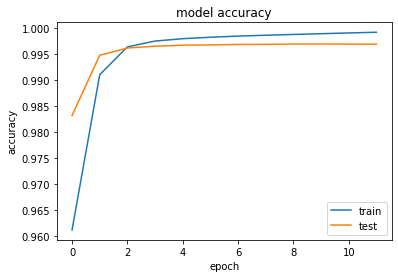

In [ ]:
#Bilstm_model
plt.plot(Bilstm_history.history['categorical_accuracy'])
plt.plot(Bilstm_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train' , 'test'], loc= "lower right")
plt.show()

**Performance_Evaluation**

In [ ]:
loss, accuracy = Bilstm_model.evaluate(X_test, y_test)
print("Bilstm_Model \nLoss: {0}, \nAccuracy: {1}".format(loss, accuracy))

162/162 [==============================] - 4s 22ms/step - loss: 0.0101 - categorical_accuracy: 0.9971
Bilstm_Model 
Loss: 0.010060087777674198, 
Accuracy: 0.9970908761024475


# **2-Simple_RNN**

In [ ]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim = vocab_size, output_dim= embedding_size,
                           input_length= MAX_LENGTH , weights=[embedding_weights], trainable= True))
rnn_model.add(SimpleRNN(64, return_sequences=True))
rnn_model.add(TimeDistributed(Dense(24)))
rnn_model.add(Activation('softmax'))
 
rnn_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=[metrics.categorical_accuracy])
 
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 325, 300)          11386200  
                                                                 
 simple_rnn (SimpleRNN)      (None, 325, 64)           23360     
                                                                 
 time_distributed_2 (TimeDis  (None, 325, 24)          1560      
 tributed)                                                       
                                                                 
 activation_2 (Activation)   (None, 325, 24)           0         
                                                                 
Total params: 11,411,120
Trainable params: 11,411,120
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn_history = rnn_model.fit(X_train, y_train, epochs=100, batch_size=128,
                                  validation_data=(X_validation , y_validation), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/100
195/195 [==============================] - 76s 383ms/step - loss: 0.3329 - categorical_accuracy: 0.9493 - val_loss: 0.0922 - val_categorical_accuracy: 0.9774
Epoch 2/100
195/195 [==============================] - 82s 423ms/step - loss: 0.0633 - categorical_accuracy: 0.9841 - val_loss: 0.0436 - val_categorical_accuracy: 0.9888
Epoch 3/100
195/195 [==============================] - 101s 517ms/step - loss: 0.0327 - categorical_accuracy: 0.9913 - val_loss: 0.0288 - val_categorical_accuracy: 0.9913
Epoch 4/100
195/195 [==============================] - 74s 378ms/step - loss: 0.0225 - categorical_accuracy: 0.9930 - val_loss: 0.0241 - val_categorical_accuracy: 0.9918
Epoch 5/100
195/195 [==============================] - 86s 439ms/step - loss: 0.0183 - categorical_accuracy: 0.9937 - val_loss: 0.0221 - val_categorical_accuracy: 0.9921
Epoch 6/100
195/195 [==============================] - 97s 497ms/step - loss: 0.0161 - categorical_accuracy: 0.9942 - val_loss: 0.0211 - val_categori

**Visualizing Training History**

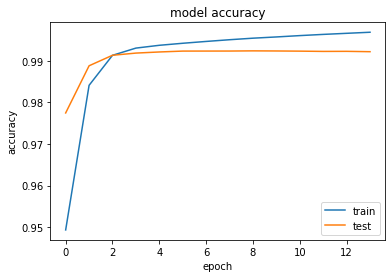

In [ ]:
#rnn_model
plt.plot(rnn_history.history['categorical_accuracy'])
plt.plot(rnn_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train' , 'test'], loc= "lower right")
plt.show()

**Performance_Evaluation**

In [ ]:
loss, accuracy = rnn_model.evaluate(X_test, y_test)
print("SimpleRNN_Model \nLoss: {0}, \nAccuracy: {1}".format(loss, accuracy))

162/162 [==============================] - 10s 61ms/step - loss: 0.0214 - categorical_accuracy: 0.9925
SimpleRNN_Model 
Loss: 0.02140483446419239, 
Accuracy: 0.9924609065055847


# **3-GRU**

In [ ]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim = vocab_size, output_dim= embedding_size, 
                        input_length= MAX_LENGTH, weights=[embedding_weights], trainable= True))
gru_model.add(GRU(256, return_sequences=True))
gru_model.add(TimeDistributed(Dense(24)))
gru_model.add(Activation('softmax'))
 
gru_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=[metrics.categorical_accuracy])
 
gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 325, 300)          11386200  
                                                                 
 gru (GRU)                   (None, 325, 256)          428544    
                                                                 
 time_distributed_3 (TimeDis  (None, 325, 24)          6168      
 tributed)                                                       
                                                                 
 activation_3 (Activation)   (None, 325, 24)           0         
                                                                 
Total params: 11,820,912
Trainable params: 11,820,912
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru_history = gru_model.fit(X_train, y_train, epochs=100, batch_size=128,
                      validation_data=(X_validation, y_validation), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')])

Epoch 1/100
195/195 [==============================] - 15s 64ms/step - loss: 0.2513 - categorical_accuracy: 0.9659 - val_loss: 0.0641 - val_categorical_accuracy: 0.9814
Epoch 2/100
195/195 [==============================] - 13s 64ms/step - loss: 0.0396 - categorical_accuracy: 0.9888 - val_loss: 0.0272 - val_categorical_accuracy: 0.9914
Epoch 3/100
195/195 [==============================] - 12s 63ms/step - loss: 0.0216 - categorical_accuracy: 0.9926 - val_loss: 0.0218 - val_categorical_accuracy: 0.9921
Epoch 4/100
195/195 [==============================] - 12s 63ms/step - loss: 0.0175 - categorical_accuracy: 0.9933 - val_loss: 0.0202 - val_categorical_accuracy: 0.9923
Epoch 5/100
195/195 [==============================] - 12s 64ms/step - loss: 0.0157 - categorical_accuracy: 0.9936 - val_loss: 0.0194 - val_categorical_accuracy: 0.9925
Epoch 6/100
195/195 [==============================] - 13s 64ms/step - loss: 0.0146 - categorical_accuracy: 0.9939 - val_loss: 0.0189 - val_categorical_acc

**Visualizing Training History**

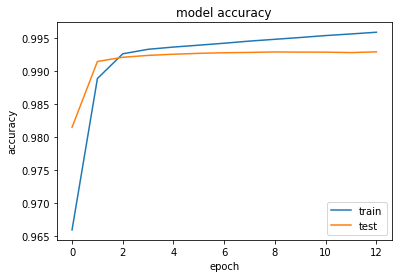

In [ ]:
#gru_model
plt.plot(gru_history.history['categorical_accuracy'])
plt.plot(gru_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train' , 'test'], loc= "lower right")
plt.show()

**Performance_Evaluation**

In [ ]:
loss, accuracy = gru_model.evaluate(X_test, y_test)
print("GRU_Model \nLoss: {0}, \nAccuracy: {1}".format(loss, accuracy))

162/162 [==============================] - 2s 11ms/step - loss: 0.0187 - categorical_accuracy: 0.9931
GRU_Model 
Loss: 0.018708888441324234, 
Accuracy: 0.9931279420852661
